In [2]:
from datetime import datetime, timedelta
import pandas as pd
# import pandas_bokeh
# pandas_bokeh.output_notebook()
%matplotlib inline
%config IPCompleter.greedy = True
import numpy as np
import matplotlib.pyplot as plt
import cbpro
import urllib.request
import ssl
import json
import time
import os
from pathlib import Path
import seaborn as sns

sns.set(
    font="Franklin Gothic Book",
    rc={
        "axes.axisbelow": False,
        "axes.edgecolor": "lightgrey",
        "axes.facecolor": "None",
        "axes.grid": False,
        "axes.labelcolor": "dimgrey",
        "axes.spines.right": False,
        "axes.spines.top": False,
        "figure.facecolor": "white",
        "lines.solid_capstyle": "round",
        "patch.edgecolor": "w",
        "patch.force_edgecolor": True,
        "text.color": "dimgrey",
        "xtick.bottom": False,
        "xtick.color": "dimgrey",
        "xtick.direction": "out",
        "xtick.top": False,
        "ytick.color": "dimgrey",
        "ytick.direction": "out",
        "ytick.left": False,
        "ytick.right": False,
    },
)

sns.set_context(
    "notebook", rc={"font.size": 16, "axes.titlesize": 20, "axes.labelsize": 18}
)

os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
os.environ["TF_GPU_THREAD_MODE"] = "gpu_private"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf

tf.distribute.OneDeviceStrategy(device="/gpu:0")
policy = tf.keras.mixed_precision.Policy("mixed_float16")
tf.keras.mixed_precision.experimental.set_policy(policy)
np.set_printoptions(suppress=True)

public_client = cbpro.PublicClient()


In [3]:
class MinerMeta(type):
    def compile_historic(self, num_days=100, write_csv=False, read_csv=False):
        file = Path.cwd() / f"{self.coin}_histdata.csv"
        if read_csv is True:
            df = pd.read_csv(file, index_col="time", infer_datetime_format=True)
            return df
        else:
            finish = datetime.now()
            start = finish - timedelta(num_days)
            delta = timedelta(hours=300)
            df = pd.DataFrame()

            while finish > start:
                historic = public_client.get_product_historic_rates(
                    f"{self.coin}-USD",
                    granularity=3600,
                    start=start,
                    end=start + delta,
                )
                start += delta
                df = df.append(historic, ignore_index=True, verify_integrity=True)
            df.columns = ["time", "low", "high", "open", "close", "volume"]
            date_time = pd.to_datetime(df["time"], unit="s")
            # df.set_index("time", inplace=True)
            df.sort_values(by="time", ascending=False, inplace=True)

            timestamp_s = date_time.map(pd.Timestamp.timestamp)
            day = 24 * 60 * 60
            year = (365.2425) * day
            df["Day sin"] = np.sin(timestamp_s * (2 * np.pi / day))
            df["Day cos"] = np.cos(timestamp_s * (2 * np.pi / day))
            df["Year sin"] = np.sin(timestamp_s * (2 * np.pi / year))
            df["Year cos"] = np.cos(timestamp_s * (2 * np.pi / year))
            df.reset_index(drop=True, inplace=True)
            df["time"] = pd.to_datetime(df["time"], unit="s")
            df.set_index("time", inplace=True, verify_integrity=False)
            df.sort_index(ascending=False)
            if write_csv is True:
                df.to_csv(file, index=True)

            return df

    def get_day_stats(self):
        result = getattr(self, "day_stats", None)
        if result is None:
            ticker = public_client.get_product_24hr_stats(f"{self.coin}-USD")
            df = pd.DataFrame.from_dict(ticker, orient="index")
            self.day_stats = df
        return df

    def year_day_fft(self, col):
        df = self.compile_historic()
        today = datetime.today()
        ylim = int(df[col].max())
        plt.figure(figsize=(15, 10))


        fft = tf.signal.rfft(df[col])
        f_per_dataset = np.arange(0, len(fft))

        n_samples_h = 1
        hours_per_year = 24 * 365.2524
        hours_per_week = 24 * 7
        years_per_dataset = n_samples_h / (hours_per_year)
        hours_per_dataset = n_samples_h / (hours_per_week)

        f_per_year = f_per_dataset / years_per_dataset
        f_per_week = f_per_dataset / hours_per_dataset
        plt.step(f_per_week, np.abs(fft))
        plt.xscale("log")
        # plt.ylim(1000, ylim)
        # plt.xlim([0.1, max(plt.xlim())])
        plt.xticks([1, 7], labels=["1/Week", "1/day"])
        plt.xlabel("Frequency (log scale)")

        return plt.show()

    def ttsplit_norm(self, df, split_time=0.7, feature_plot=False):
        # train_df Test Split
        n = len(df)
        train_df = df[0 : int(n * 0.7)]
        val_df = df[int(n * 0.7) : int(n * 0.9)]
        test_df = df[int(n * 0.9) :]
        # Normalize the Data
        train_df_mean = train_df.mean()
        train_df_std = train_df.std()

        train_df = (train_df - train_df_mean) / train_df_std
        val_df = (val_df - train_df_mean) / train_df_std
        test_df = (test_df - train_df_mean) / train_df_std

        # Create Feature Plot if wanted
        if feature_plot is True:
            df_std = (df - train_df_mean) / train_df_std
            df_std = df_std.melt(var_name="Column", value_name="Normalized")
            plt.figure(figsize=(12, 6))
            ax = sns.violinplot(x="Column", y="Normalized", data=df_std)
            ax.set_xticklabels(df.keys(), rotation=90)
            ax.set_title("train_dfing Data Feature Dist with whole DF Mean")

            return train_df, val_df, test_df

        return train_df, val_df, test_df

    def __call__(self, *args, **kwargs):

        cls = type.__call__(self, *args)

        # setattr(cls, "compile_historic", self.compile_historic)
        # setattr(cls, "year_day_fft", self.year_day_fft)
        # setattr(cls, "ttsplit_norm", self.ttsplit_norm)
        # setattr(cls, "get_day_stats", self.get_day_stats)
        setattr(cls, "day_stats", self.get_day_stats())

        # for key, value in historic.items():
        #     setattr(cls, "hist_" + key, value)
        # for key, value in ticker.items():
        #     setattr(cls, "tick_" + key, value)

        return cls


class eth(metaclass=MinerMeta):
    coin = "eth"


In [4]:
# Lunar Crush API Key
# https://lunarcrush.com/developers/docs#assets
api_key = r"ru1zaf0ssaa29394mb4ahp"

# coins = ["BTC", "ETH", "LTC"]
coins = "ETH"
file = Path.cwd() / "lunardata.csv"

# coins = ",".join(coins)

map = [
    {"name": ""},
    {"symbol": ""},
    {"price": " Price: "},
    {"percent_change_24h": " - 24 Hour Percent Change: "},
    {"average_sentiment": " Average Sentiment: "},
]


def final_render(asset_coin, value, key, asset):
    if key == "symbol":
        asset_coin += " (" + asset[key] + ")"
    elif key == "percent_change_24h":
        asset_coin += value + str(asset[key]) + "%"
    else:
        asset_coin += value + str(asset[key])
    return asset_coin


def lc_data(read_csv=False):
    file = Path.cwd() / "lunardata.csv"
    if read_csv is True:
        data = pd.read_csv(file, index_col="id")
        return data
    else:
        assets_url = (
            "https://api.lunarcrush.com/v2?data=assets&key="
            + api_key
            + "&symbol="
            + coins
        )
        assets = json.loads(urllib.request.urlopen(assets_url).read())
        # config = pd.DataFrame.from_dict(assets["config"], orient="index")
        # usage = pd.DataFrame.from_dict(assets["usage"], orient="index")
        data = pd.DataFrame.from_dict(assets["data"])
        return data

    # feeds_url = (
    #     "https://api.lunarcrush.com/v2?data=feeds&key=" + api_key + "&symbol=" + coins
    # )
    # assets = json.loads(urllib.request.urlopen(feeds_url).read())
    # print(assets)
    # config = pd.DataFrame.from_dict(assets["config"])

    # time_series = pd.DataFrame.from_dict(assets["timeSeries"])
    # for asset in assets["data"]:
    #     asset_coin = ""
    #     for field in map:
    #         print(field)
    #     key = list(field.keys())[0]
    #     value = list(field.values())[0]
    #     asset_coin = final_render(asset_coin, value, key, asset)


In [5]:
data = lc_data(read_csv=True)
data.head()

,name,symbol,price,price_btc,market_cap,percent_change_24h,percent_change_7d,percent_change_30d,volume_24h,max_supply,...,social_contributors,social_volume,social_volume_global,social_dominance,market_cap_global,market_dominance,youtube,medium,tags,close
id,,,,,,,,,,,,,,,,,,,,,
2,Ethereum,ETH,3038.992665,0.069678,357484917776,9.79,-15.96,-8.63,8.812581e+10,113561765,...,1238,4601,64597,7.122622,2256317895317,15.824621,2,1,NaN,3038.992665


In [6]:
df = eth.compile_historic(read_csv=True)
num_features = df.shape[1]

train_df, val_df, test_df = eth.ttsplit_norm(df)


In [7]:
class WindowGenerator:
    def __init__(
        self,
        input_width,
        label_width,
        shift,
        label_columns=None,
        df=df,
        train_df=train_df,
        val_df=val_df,
        test_df=test_df,
    ):
        # Store the raw data.
        self.df = df
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {
                name: i for i, name in enumerate(label_columns)
            }
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [
                    labels[:, :, self.column_indices[name]]
                    for name in self.label_columns
                ],
                axis=-1,
            )

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def make_ds(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,
        )

        ds = ds.map(self.split_window)

        return ds

    def plot(self, model=None, plot_col="close", max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(15, 10))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n + 1)
            plt.ylabel(f"{plot_col} [normed]")
            plt.plot(
                self.input_indices,
                inputs[n, :, plot_col_index],
                label="Inputs",
                marker=".",
                zorder=-10,
            )

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(
                self.label_indices,
                labels[n, :, label_col_index],
                # edgecolors="k",
                # label="Labels",
                # c="#2ca02c",
                s=64,
            )
            if model is not None:
                predictions = model(inputs)
                plt.scatter(
                    self.label_indices,
                    predictions[n, :, label_col_index],
                    marker="X",
                    # edgecolors="k",
                    # label="Predictions",
                    # c="#ff7f0e",
                    s=64,
                )

            if n == 0:
                plt.legend()

        plt.xlabel("Time [h]")

    @property
    def train(self):
        return self.make_ds(self.train_df)

    @property
    def val(self):
        return self.make_ds(self.val_df)

    @property
    def test(self):
        return self.make_ds(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, "_example", None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

    def __repr__(self):
        return "\n".join(
            [
                f"Total window size: {self.total_window_size}",
                f"Input indices: {self.input_indices}",
                f"Label indices: {self.label_indices}",
                f"Label column name(s): {self.label_columns}",
            ]
        )


In [16]:
MAX_EPOCHS = 20


def compile_and_fit(model, window, patience=3):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=patience, mode="min"
    )

    model.compile(
        loss=tf.losses.MeanSquaredError(),
        optimizer=tf.optimizers.Adam(),
        metrics=[tf.metrics.MeanAbsoluteError()],
    )

    history = model.fit(
        window.train,
        epochs=MAX_EPOCHS,
        validation_data=window.val,
        callbacks=[early_stopping],
    )
    return history


In [17]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [18]:
OUT_STEPS = 24 * 7
multi_val_performance = {}
multi_performance = {}
multi_window = WindowGenerator(
    input_width=OUT_STEPS, label_width=OUT_STEPS, shift=OUT_STEPS
)


Epoch 1/20
43/43 [==============================] - 4s 34ms/step - loss: 0.2862 - mean_absolute_error: 0.3375 - val_loss: 0.2207 - val_mean_absolute_error: 0.3269
Epoch 2/20
43/43 [==============================] - 1s 25ms/step - loss: 0.1836 - mean_absolute_error: 0.2143 - val_loss: 0.2365 - val_mean_absolute_error: 0.3287
Epoch 3/20
43/43 [==============================] - 1s 25ms/step - loss: 0.1610 - mean_absolute_error: 0.1926 - val_loss: 0.2303 - val_mean_absolute_error: 0.3264
Epoch 4/20
5/5 [==============================] - 0s 10ms/step - loss: 0.2286 - mean_absolute_error: 0.3302
Wall time: 7.72 s


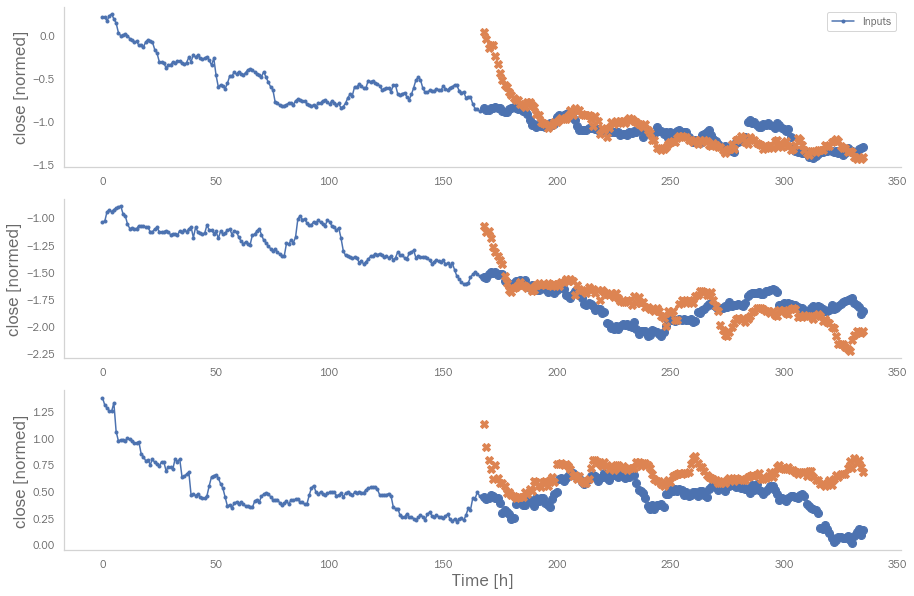

In [20]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, multi_window)

multi_val_performance['Residual LSTM'] = residual_lstm.evaluate(multi_window.val)
multi_performance['Residual LSTM'] = residual_lstm.evaluate(multi_window.test, verbose=0)
multi_window.plot(residual_lstm)

Epoch 1/20
43/43 [==============================] - 11s 87ms/step - loss: 0.2197 - mean_absolute_error: 0.3023 - val_loss: 0.5596 - val_mean_absolute_error: 0.6353
Epoch 2/20
43/43 [==============================] - 2s 43ms/step - loss: 0.1218 - mean_absolute_error: 0.1790 - val_loss: 0.4047 - val_mean_absolute_error: 0.5144
Epoch 3/20
43/43 [==============================] - 2s 42ms/step - loss: 0.1048 - mean_absolute_error: 0.1554 - val_loss: 0.3770 - val_mean_absolute_error: 0.5026
Epoch 4/20
43/43 [==============================] - 2s 44ms/step - loss: 0.0910 - mean_absolute_error: 0.1395 - val_loss: 0.4618 - val_mean_absolute_error: 0.5566
Epoch 5/20
43/43 [==============================] - 3s 59ms/step - loss: 0.0819 - mean_absolute_error: 0.1327 - val_loss: 0.5074 - val_mean_absolute_error: 0.5999
Epoch 6/20
5/5 [==============================] - 0s 26ms/step - loss: 0.7599 - mean_absolute_error: 0.7277


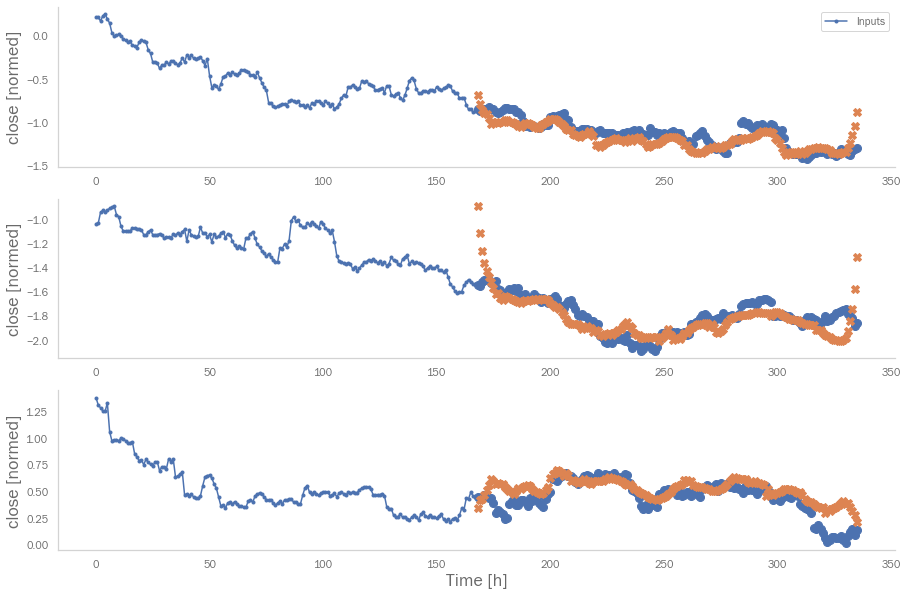

In [21]:
CONV_WIDTH = 3

dev_model = tf.keras.models.Sequential(
    [
        # tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
        tf.keras.layers.Conv1D(
            filters=64,
            kernel_size=(CONV_WIDTH),
            strides=1,
            padding="causal",
            activation="relu",
        ),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
        # tf.keras.layers.Bidirectional(
        #     tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.Dense(128),
        # tf.keras.layers.Dropout(.2),
        tf.keras.layers.Dense(num_features),
    ]
)

history = compile_and_fit(dev_model, multi_window)

multi_val_performance["DEV"] = dev_model.evaluate(multi_window.val)
multi_performance["DEV"] = dev_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(dev_model)


In [15]:
# for name, value in multi_performance.items():
#     print(f"{name:8s}: {value[1]:0.4f}")
print(multi_performance.items())

dict_items([('Residual LSTM', [])])


In [ ]:
OUT_STEPS = 7
multi_val_performance = {}
multi_performance = {}
multi_window = WindowGenerator(
    input_width=OUT_STEPS, label_width=OUT_STEPS, shift=OUT_STEPS
)


In [22]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test)
multi_window.plot(multi_dense_model)


Epoch 1/20
43/43 [==============================] - 1s 16ms/step - loss: 0.4146 - mean_absolute_error: 0.4775 - val_loss: 0.3642 - val_mean_absolute_error: 0.4497
Epoch 2/20
43/43 [==============================] - 1s 13ms/step - loss: 0.1487 - mean_absolute_error: 0.2249 - val_loss: 0.3601 - val_mean_absolute_error: 0.4604
Epoch 3/20
43/43 [==============================] - 1s 11ms/step - loss: 0.1313 - mean_absolute_error: 0.1851 - val_loss: 0.3761 - val_mean_absolute_error: 0.4886
Epoch 4/20
43/43 [==============================] - 1s 12ms/step - loss: 0.1276 - mean_absolute_error: 0.1775 - val_loss: 0.3965 - val_mean_absolute_error: 0.4997
Epoch 5/20
5/5 [==============================] - 0s 8ms/step - loss: 0.4590 - mean_absolute_error: 0.5447


c:\Users\jadav\Desktop\underminer\env\lib\site-packages\keras\utils\generic_utils.py:915: RuntimeWarning: divide by zero encountered in log10
  numdigits = int(np.log10(self.target)) + 1


OverflowError: cannot convert float infinity to integer

In [ ]:
df = multi_window.df
df.plot_bokeh()